In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
W0515 14:32:56.780000 32924 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [2]:
csv_path = "dummy_emergency_patients_flexible_2500.csv"  
df = pd.read_csv(csv_path)
df.head()


,patient_id,description,triage_level
0,P00001,Severe persistent trauma noted after a fall.,2
1,P00002,moderate seizure observed during daily activit...,2
2,P00003,mild shortness of breath was triggered by stre...,1
3,P00004,Mild mild sore throat reported with no other s...,4
4,P00005,Severe moderate chest pain noted after a fall.,1


In [3]:
# remove duplicated description
df_unique = df.drop_duplicates(subset="description").reset_index(drop=True)

# stratified split
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(
    df_unique, 
    test_size=0.2, 
    stratify=df_unique["triage_level"], 
    random_state=42
)

# shuffle
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("Duplicated description removed and shuffled")


Duplicated description removed and shuffled


In [4]:
# Calculate how many rows were removed due to duplicate descriptions
original_count = len(df)
unique_count = len(df_unique)
removed_count = original_count - unique_count

print(f"📄 Original dataset size: {original_count}")
print(f"✅ After removing duplicates: {unique_count}")
print(f"❌ Number of duplicate descriptions removed: {removed_count}")


📄 Original dataset size: 2500
✅ After removing duplicates: 2500
❌ Number of duplicate descriptions removed: 0


In [5]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

unique_labels = sorted(df_unique["triage_level"].unique())
label2id = {int(lvl): i for i, lvl in enumerate(unique_labels)}
id2label = {i: str(lvl) for lvl, i in label2id.items()}

train_dataset = train_dataset.map(lambda x: {"label": label2id[int(x["triage_level"])]})
test_dataset = test_dataset.map(lambda x: {"label": label2id[int(x["triage_level"])]})


Map: 100%|██████████| 500/500 [00:00<00:00, 16666.55 examples/s]


In [6]:
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(
        example["description"],
        padding="max_length",
        truncation=True,
        max_length=64
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=5,
    id2label=id2label,
    label2id=label2id
)


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Map: 100%|██████████| 500/500 [00:00<00:00, 17241.35 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results_no_save2",      # Output directory still needed
    save_strategy="no",                  # Do not save checkpoints
    evaluation_strategy="epoch",         # Keep evaluating (optional)
    logging_strategy="epoch",            # Keep logging (optional)
    learning_rate=3e-2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs_no_save2",
    logging_steps=999999
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    report = classification_report(labels, preds, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "f1": report["weighted avg"]["f1-score"]
    }

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

In [8]:
trainer.train()

  0%|          | 0/1250 [00:00<?, ?it/s]

 10%|█         | 125/1250 [00:23<03:43,  5.04it/s]

{'loss': 5.5292, 'grad_norm': 19.51273536682129, 'learning_rate': 0.027, 'epoch': 1.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 2.72114634513855, 'eval_accuracy': 0.186, 'eval_f1': 0.058340640809443504, 'eval_runtime': 1.87, 'eval_samples_per_second': 267.38, 'eval_steps_per_second': 17.112, 'epoch': 1.0}


 20%|██        | 250/1250 [00:52<03:53,  4.28it/s]

{'loss': 4.5922, 'grad_norm': 26.54560089111328, 'learning_rate': 0.024, 'epoch': 2.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 4.358441352844238, 'eval_accuracy': 0.216, 'eval_f1': 0.07673684210526314, 'eval_runtime': 2.484, 'eval_samples_per_second': 201.288, 'eval_steps_per_second': 12.882, 'epoch': 2.0}


 30%|███       | 375/1250 [01:26<03:47,  3.85it/s]

{'loss': 3.7116, 'grad_norm': 19.87591552734375, 'learning_rate': 0.020999999999999998, 'epoch': 3.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 4.2484283447265625, 'eval_accuracy': 0.234, 'eval_f1': 0.0887455429497569, 'eval_runtime': 2.697, 'eval_samples_per_second': 185.391, 'eval_steps_per_second': 11.865, 'epoch': 3.0}


 40%|████      | 500/1250 [02:02<03:12,  3.90it/s]

{'loss': 3.631, 'grad_norm': 8.372102737426758, 'learning_rate': 0.018, 'epoch': 4.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 1.9264689683914185, 'eval_accuracy': 0.234, 'eval_f1': 0.0887455429497569, 'eval_runtime': 2.665, 'eval_samples_per_second': 187.617, 'eval_steps_per_second': 12.008, 'epoch': 4.0}


 50%|█████     | 625/1250 [02:37<02:42,  3.85it/s]

{'loss': 3.324, 'grad_norm': 8.379332542419434, 'learning_rate': 0.015, 'epoch': 5.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 1.8125475645065308, 'eval_accuracy': 0.216, 'eval_f1': 0.07673684210526314, 'eval_runtime': 2.661, 'eval_samples_per_second': 187.899, 'eval_steps_per_second': 12.026, 'epoch': 5.0}


 60%|██████    | 750/1250 [03:13<02:11,  3.81it/s]

{'loss': 2.9768, 'grad_norm': 9.21501350402832, 'learning_rate': 0.012, 'epoch': 6.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 1.898181438446045, 'eval_accuracy': 0.216, 'eval_f1': 0.07673684210526314, 'eval_runtime': 2.736, 'eval_samples_per_second': 182.749, 'eval_steps_per_second': 11.696, 'epoch': 6.0}


 70%|███████   | 875/1250 [03:49<01:35,  3.94it/s]

{'loss': 2.5998, 'grad_norm': 8.551874160766602, 'learning_rate': 0.009, 'epoch': 7.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 2.5763165950775146, 'eval_accuracy': 0.216, 'eval_f1': 0.07673684210526314, 'eval_runtime': 2.591, 'eval_samples_per_second': 192.973, 'eval_steps_per_second': 12.35, 'epoch': 7.0}


 80%|████████  | 1000/1250 [04:25<01:03,  3.93it/s]

{'loss': 2.3395, 'grad_norm': 21.028749465942383, 'learning_rate': 0.006, 'epoch': 8.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 2.5511724948883057, 'eval_accuracy': 0.234, 'eval_f1': 0.0887455429497569, 'eval_runtime': 2.555, 'eval_samples_per_second': 195.698, 'eval_steps_per_second': 12.525, 'epoch': 8.0}


 90%|█████████ | 1125/1250 [05:00<00:32,  3.88it/s]

{'loss': 2.0529, 'grad_norm': 10.649298667907715, 'learning_rate': 0.003, 'epoch': 9.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 1.724073886871338, 'eval_accuracy': 0.258, 'eval_f1': 0.10582511923688394, 'eval_runtime': 2.542, 'eval_samples_per_second': 196.695, 'eval_steps_per_second': 12.589, 'epoch': 9.0}


100%|██████████| 1250/1250 [05:35<00:00,  3.86it/s]

{'loss': 1.86, 'grad_norm': 7.549561500549316, 'learning_rate': 0.0, 'epoch': 10.0}


c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

{'eval_loss': 1.5804872512817383, 'eval_accuracy': 0.258, 'eval_f1': 0.10582511923688394, 'eval_runtime': 2.605, 'eval_samples_per_second': 191.938, 'eval_steps_per_second': 12.284, 'epoch': 10.0}
{'train_runtime': 338.4622, 'train_samples_per_second': 59.091, 'train_steps_per_second': 3.693, 'train_loss': 3.2616888671875, 'epoch': 10.0}


TrainOutput(global_step=1250, training_loss=3.2616888671875, metrics={'train_runtime': 338.4622, 'train_samples_per_second': 59.091, 'train_steps_per_second': 3.693, 'train_loss': 3.2616888671875, 'epoch': 10.0})

In [9]:
eval_metrics = trainer.evaluate()
print(f"\n Eval loss (cross-entropy): {eval_metrics['eval_loss']:.4f}")

 94%|█████████▍| 30/32 [00:02<00:00, 13.43it/s]c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod


 Eval loss (cross-entropy): 1.5805


In [10]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize

# Predict
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true = preds_output.label_ids

# Label names
labels = [f"Level {id2label[i]}" for i in range(5)]
report = classification_report(true, preds, target_names=labels, output_dict=True)
cm = confusion_matrix(true, preds)

# Core metrics
accuracy = accuracy_score(true, preds)
precision = precision_score(true, preds, average="macro")
recall = recall_score(true, preds, average="macro")
f1 = report["weighted avg"]["f1-score"]

# ROC-AUC
true_binarized = label_binarize(true, classes=list(range(5)))
preds_binarized = label_binarize(preds, classes=list(range(5)))
roc_auc = roc_auc_score(true_binarized, preds_binarized, average="macro", multi_class="ovr")

# Test loss
test_loss = preds_output.metrics["test_loss"]

# Hyperparameters to record
experiment_config = {
    "model_name": model_name,
    "learning_rate": training_args.learning_rate,
    "train_batch_size": training_args.per_device_train_batch_size,
    "eval_batch_size": training_args.per_device_eval_batch_size,
    "num_epochs": training_args.num_train_epochs
}

# ➕ Add all results to JSON
report["overall"] = {
    "accuracy": accuracy,
    "macro_precision": precision,
    "macro_recall": recall,
    "f1_score": f1,
    "roc_auc_macro": roc_auc,
    "test_loss": test_loss  
}
report["config"] = experiment_config

# Save as JSON
os.makedirs("./output", exist_ok=True)
with open("./output/evaluation_metrics.json", "w") as f:
    json.dump(report, f, indent=4)

print("✅ Saved evaluation_metrics.json (including test_loss)")


 97%|█████████▋| 31/32 [00:02<00:00, 12.25it/s]c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

✅ Saved evaluation_metrics.json (including test_loss)



c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result

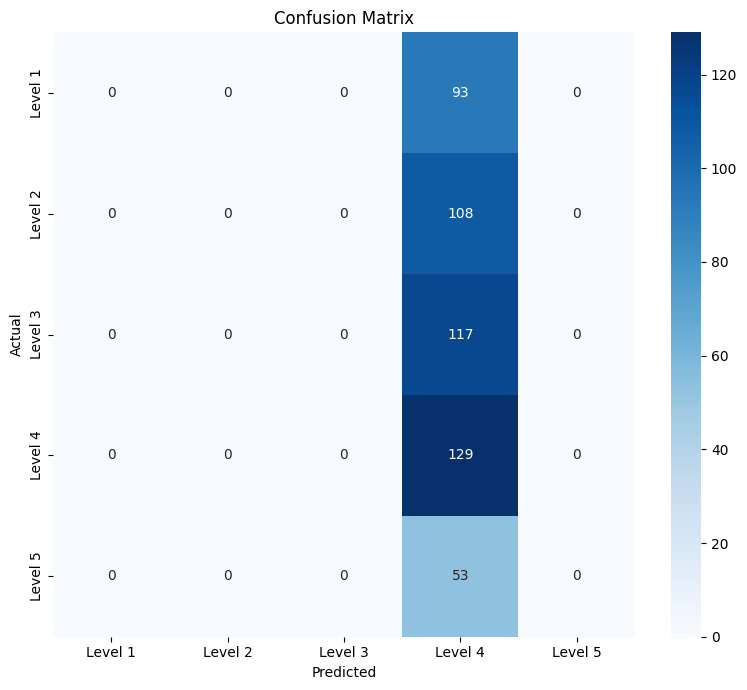

In [11]:
# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig("./output/confusion_matrix.png")
plt.show()

In [12]:
print("\nExperiment Configuration:\n")
for key, value in report["config"].items():
    print(f"{key:>20}: {value}")

print("\nModel Evaluation Summary:\n")
overall = report["overall"]
for metric, value in overall.items():
    print(f"{metric:>20}: {value:.4f}")


Experiment Configuration:

          model_name: emilyalsentzer/Bio_ClinicalBERT
       learning_rate: 0.03
    train_batch_size: 16
     eval_batch_size: 16
          num_epochs: 10

Model Evaluation Summary:

            accuracy: 0.2580
     macro_precision: 0.0516
        macro_recall: 0.2000
            f1_score: 0.1058
       roc_auc_macro: 0.5000
           test_loss: 1.5805


In [13]:
# model.save_pretrained("./saved_model")
# tokenizer.save_pretrained("./saved_tokenizer")


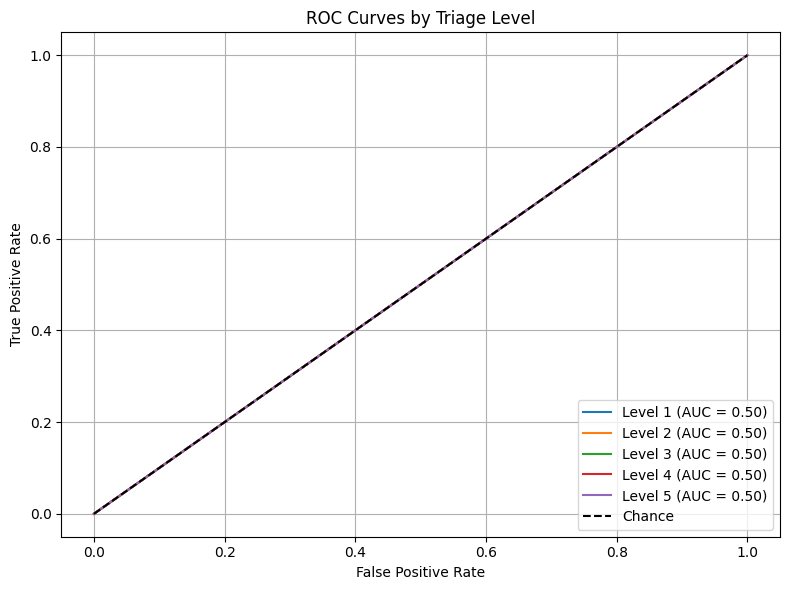

In [14]:
fpr, tpr, roc_auc_curve = {}, {}, {}

for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(true_binarized[:, i], preds_binarized[:, i])
    roc_auc_curve[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f"Level {id2label[i]} (AUC = {roc_auc_curve[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance")
plt.title("ROC Curves by Triage Level")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig("./output/roc_curves.png")
plt.show()


In [15]:
intersection = set(train_df['description']).intersection(set(test_df['description']))
print("🚨 amount of duplicated description:", len(intersection))


🚨 amount of duplicated description: 0


📊 Label distribution in training set:
triage_level
1    374
2    434
3    467
4    513
5    212
Name: count, dtype: int64 

📊 Label distribution in test set:
triage_level
1     93
2    108
3    117
4    129
5     53
Name: count, dtype: int64 



100%|██████████| 32/32 [00:02<00:00, 14.72it/s]c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\HYUN\anaconda3\envs\nlp-clean\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mod

📈 Classification Report:

              precision    recall  f1-score   support

     Level 1       0.00      0.00      0.00        93
     Level 2       0.00      0.00      0.00       108
     Level 3       0.00      0.00      0.00       117
     Level 4       0.26      1.00      0.41       129
     Level 5       0.00      0.00      0.00        53

    accuracy                           0.26       500
   macro avg       0.05      0.20      0.08       500
weighted avg       0.07      0.26      0.11       500



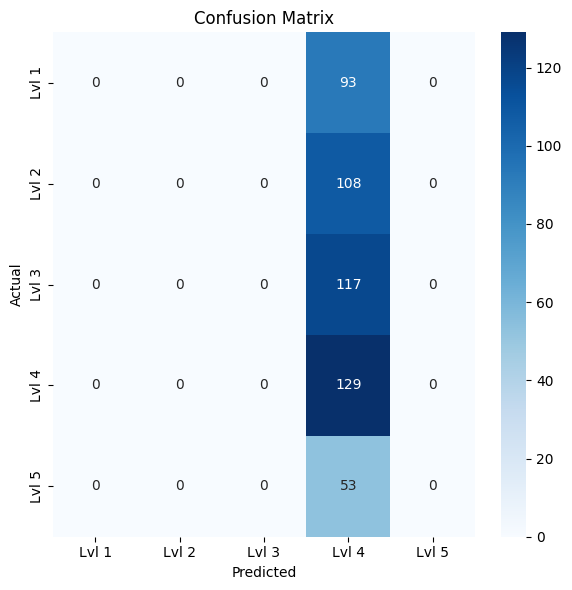


❌ Top 10 Incorrect Predictions:


,description,true_label,predicted_label,confidence
0,severe trauma present along with weakness.,1,4,7.972297
2,Patient reports episode of itchy skin. while w...,5,4,7.972297
3,Patient reports persistent skin rash after exe...,5,4,7.972297
6,mild nausea occurred with vomiting and nausea.,3,4,7.972297
8,Patient noticed complaints of blurred vision a...,1,4,7.972297
9,intermittent chest pain began suddenly and is ...,1,4,7.972297
11,Noted unresponsive. while walking,1,4,7.972297
13,Experiencing severe bleeding.,1,4,7.972297
15,Complaint of persistent trauma after exposure ...,1,4,7.972297
16,Recent episode of recent dizziness and episode...,3,4,7.972297



🔍 Avg Confidence per True Class:
label
0    7.972297
1    7.972297
2    7.972297
3    7.972297
4    7.972297
Name: confidence, dtype: float32

🔁 Raw Confusion Matrix:


,Pred_1,Pred_2,Pred_3,Pred_4,Pred_5
True_1,0,0,0,93,0
True_2,0,0,0,108,0
True_3,0,0,0,117,0
True_4,0,0,0,129,0
True_5,0,0,0,53,0


In [16]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Check label distribution in train/test
print("📊 Label distribution in training set:")
print(train_df["triage_level"].value_counts().sort_index(), "\n")

print("📊 Label distribution in test set:")
print(test_df["triage_level"].value_counts().sort_index(), "\n")

# 2. Get predictions and labels
preds_output = trainer.predict(test_dataset)
preds = np.argmax(preds_output.predictions, axis=1)
true = preds_output.label_ids
probs = np.max(preds_output.predictions, axis=1)

# 3. Classification report
print("📈 Classification Report:\n")
print(classification_report(true, preds, target_names=[f"Level {id2label[i]}" for i in range(5)]))

# 4. Confusion matrix
cm = confusion_matrix(true, preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[f"Lvl {id2label[i]}" for i in range(5)],
            yticklabels=[f"Lvl {id2label[i]}" for i in range(5)])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 5. Analyze incorrect predictions
wrong_mask = preds != true
wrong_examples = test_df.iloc[wrong_mask]
wrong_examples = wrong_examples.copy()
wrong_examples["true_label"] = [id2label[i] for i in true[wrong_mask]]
wrong_examples["predicted_label"] = [id2label[i] for i in preds[wrong_mask]]
wrong_examples["confidence"] = probs[wrong_mask]

print("\n❌ Top 10 Incorrect Predictions:")
display(wrong_examples[["description", "true_label", "predicted_label", "confidence"]].head(10))

# 6. Average prediction confidence per class
conf_df = pd.DataFrame({"label": true, "pred": preds, "confidence": probs})
print("\n🔍 Avg Confidence per True Class:")
print(conf_df.groupby("label")["confidence"].mean())

# 7. (Optional) Show most confusing class pairs
cm_df = pd.DataFrame(cm, columns=[f"Pred_{id2label[i]}" for i in range(5)],
                        index=[f"True_{id2label[i]}" for i in range(5)])
print("\n🔁 Raw Confusion Matrix:")
display(cm_df)
